<a href="https://colab.research.google.com/github/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/blob/master/CPI_vs_Occupancy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPI and Shelter Occupancy Analysis


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn
import scipy, scipy.stats
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Take a random sample of x records from DataFrame y:
def sample(df,number_of_records):
  display(df.loc[np.random.choice(len(df),number_of_records),:])
  #print('DataFrame has length',len(df), 'and shape',df.shape,'.')
  print(f'Random sample of {number_of_records} rows from DataFrame with {df.shape[0]} records and {df.shape[1]} columns.')

**Import Data**

In [3]:
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {len(df)} records from the {year} file.')

cpi_data = pd.read_csv(path + 'CPI_MONTHLY.csv', header=20, names=['date', 'CPI', 'CPI_adj', 'Static', 'CPI_TRIM', 
                                                      'CPI_MEDIAN', 'CPI_COMMON', 'ATOM', 'CPIXFET', 'CPIW'])

Loaded 38700 records from the 2017 file.
Loaded 37770 records from the 2018 file.
Loaded 39446 records from the 2019 file.


In [4]:
# Concatenate DataFrames
daily_shelter_occupancy = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in daily_shelter_occupancy.columns] 
daily_shelter_occupancy.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
daily_shelter_occupancy = daily_shelter_occupancy[cols]

# Show sample records
sample(daily_shelter_occupancy,5)

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
34598,2017,34599,2017-11-22,The Salvation Army of Canada,Salvation Army - Hope,167 College Street,Toronto,ON,M5T-1P7,S.A. Hope - 167 College St,Salvation Army Hope - Main Shelter Beds,Men,0,0.0
102869,2019,26400,2019-09-03,The MUC Shelter Corporation,Sojourn House,101 Ontario Street,Toronto,ON,M5A 2V2,Sojourn House,Sojourn House Transitional Housing Program,Families,81,76.0
47799,2018,9100,2018-03-28,City of Toronto,Seaton House,339 George Street,Toronto,ON,M5A-2N2,Seaton House - 339 George Street,Seaton House - Long Term Program,Men,95,100.0
38280,2017,38281,2017-12-28,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0
24326,2017,24327,2017-08-15,YMCA of Greater Toronto,YMCA House,485 Queen St West,Toronto,ON,M5V 2A9,Yhouse - Vanauley,YMCA House-Vanauley,Youth,40,40.0


Random sample of 5 rows from DataFrame with 115916 records and 14 columns.


**Data cleaning**

In [5]:
# Identify columns with missing values:
for col in daily_shelter_occupancy.columns:
  null_count = daily_shelter_occupancy[col].isna().sum()
  if null_count >0:
    print(f'The {col} column has {null_count} rows without values.')

The shelter_postal_code column has 5494 rows without values.
The capacity column has 343 rows without values.


In [6]:
# Drop 343 rows with null capacity
original_row_count=daily_shelter_occupancy.shape[0]
daily_shelter_occupancy.dropna(subset=['capacity'], inplace=True)
dropped_row_count=original_row_count-daily_shelter_occupancy.shape[0]
print(f'Dropped {dropped_row_count} of {original_row_count} rows, due to nulls in capacity column.')

Dropped 343 of 115916 rows, due to nulls in capacity column.


**Prepare and align data**

In [7]:
# After removing nulls, change capacity column to integer
daily_shelter_occupancy.capacity = daily_shelter_occupancy.capacity.astype(int)

daily = daily_shelter_occupancy.set_index('occupancy_date')\
  .resample('D')[['occupancy','capacity']].sum()
daily['vacancy']=daily.capacity - daily.occupancy
daily['occupancy_rate']=daily.occupancy/daily.capacity*100
# monthly average occupancy
monthly = daily.resample('M')[['occupancy','capacity','vacancy']].mean()

monthly_df = monthly.reset_index()
# reformat shelter period 
monthly_df['year_month']=pd.to_datetime(monthly_df['occupancy_date']).dt.to_period('M')
# reformat CPI period
cpi_data['year_month']=pd.to_datetime(cpi_data['date']).dt.to_period('M')

# align CPI time with occupancy based on occupancy time
df = monthly_df.set_index('year_month').join(cpi_data.set_index('year_month'), lsuffix='_gas', rsuffix='_oil')
df.head()

,occupancy_date,occupancy,capacity,vacancy,date,CPI,CPI_adj,Static,CPI_TRIM,CPI_MEDIAN,CPI_COMMON,ATOM,CPIXFET,CPIW
year_month,,,,,,,,,,,,,,
2017-01,2017-01-31,4548.096774,4863.419355,315.322581,2017-01-01,129.5,130.1,2.1,1.6,1.8,1.3,1.7,2.1,1.5
2017-02,2017-02-28,4598.750000,4896.428571,297.678571,2017-02-01,129.7,129.9,2.0,1.6,1.7,1.3,1.7,2.0,1.5
2017-03,2017-03-31,4664.612903,4901.838710,237.225806,2017-03-01,129.9,129.7,1.6,1.4,1.6,1.3,1.3,1.6,1.1
2017-04,2017-04-30,4778.466667,5032.666667,254.200000,2017-04-01,130.4,130.1,1.6,1.4,1.5,1.3,1.1,1.5,1.0
2017-05,2017-05-31,4827.967742,5078.677419,250.709677,2017-05-01,130.5,129.9,1.3,1.3,1.4,1.3,0.9,1.3,0.7


**Time Series plots**

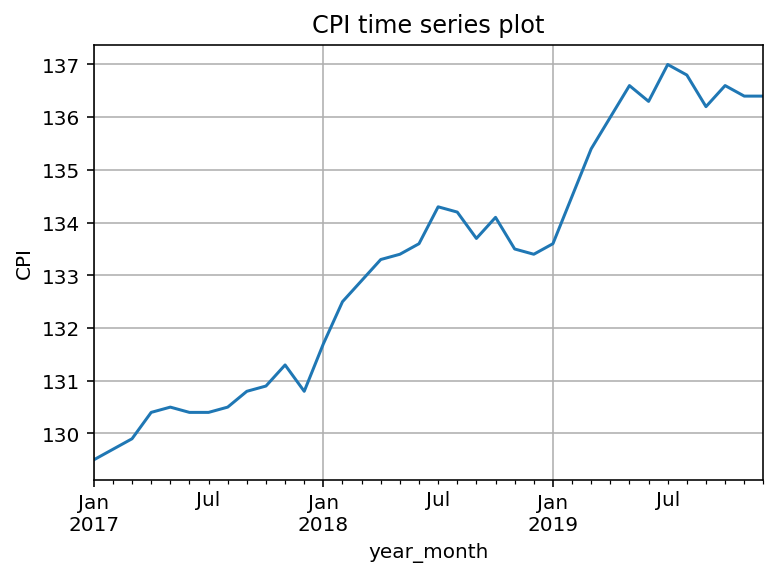

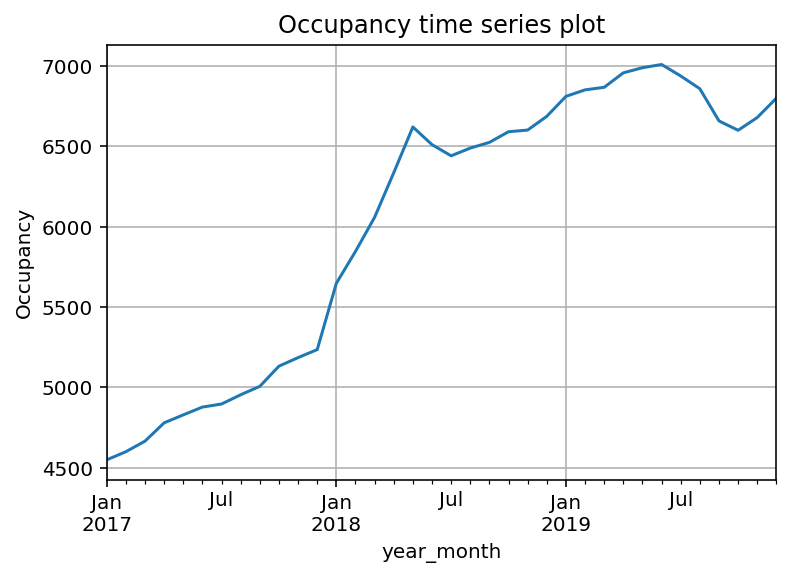

In [8]:
plt.figure();
df.CPI.plot(grid=True);
plt.ylabel('CPI');
plt.title('CPI time series plot');
plt.figure();
df.occupancy.plot(grid=True);
plt.ylabel('Occupancy');
plt.title('Occupancy time series plot');

From time series plots both occupancy and CPI data trends together from Jan 2017 to Jan 2019 after which occupancy data slope changed and trend slowed down as CPI continued to trend up.  

**Scatter plot of Occupancy vs CPI and correlation**

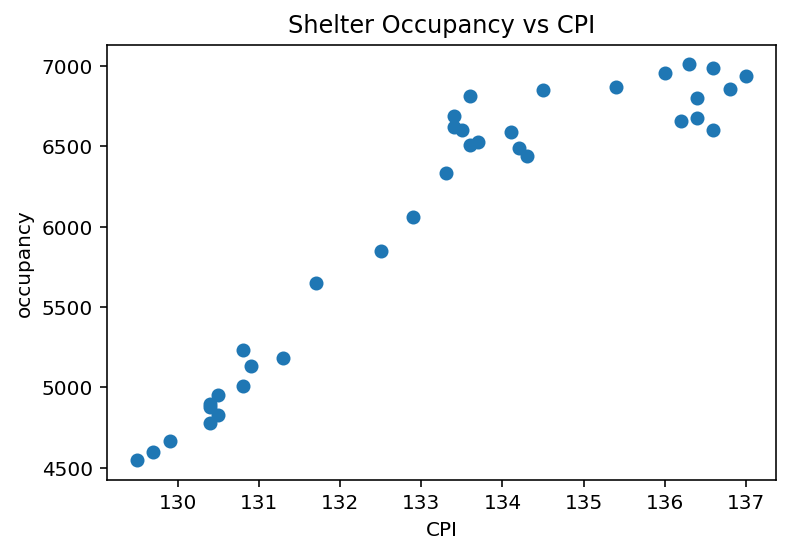

In [9]:
df2 = df.reset_index()
data = df2[['occupancy', 'CPI']]
plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations');
plt.xlabel('CPI');
plt.ylabel('occupancy');
plt.title('Shelter Occupancy vs CPI');

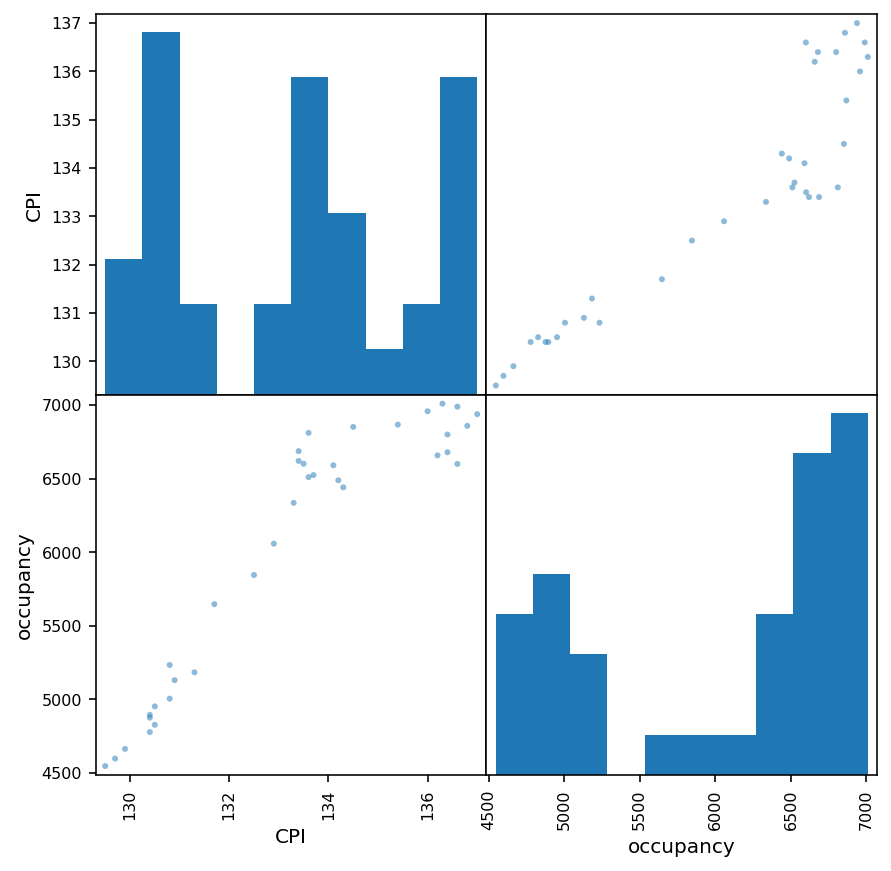

In [10]:
pd.plotting.scatter_matrix(data[['CPI', 'occupancy']], figsize= (7,7));

In [11]:
data[['CPI', 'occupancy']].corr()

,CPI,occupancy
CPI,1.000000,0.932466
occupancy,0.932466,1.000000


From scatter plot and correlation analysis we can see there is a strong correlation between CPI and occupancy. Similar to what we oberved previously in the time series plot the slope of linear relationship changes suddenly at values of CPI > 135. If we try to model occupancy using CPI as predictor and since both are time series data we need to exclude sudden changes and build a model to predict the gradual change. In the next section we use linear regression to model occupancy with CPI.

In [12]:
#data['xform'] = data['CPI']**.5
#data['xform'] = np.log(data['CPI'])
#plt.plot(data.xform, data.occupancy, 'o', label = 'Observations')
#plt.xlabel('transformed CPI')
#plt.ylabel('occupancy')
#plt.title('Shelter Occupancy vs transformed CPI')

**Linear Regression Analysis**

Let us first try to fit a linear model to the data without any transformation and/or removal of outliers. OLS from statsmodels is used to perform this analysis

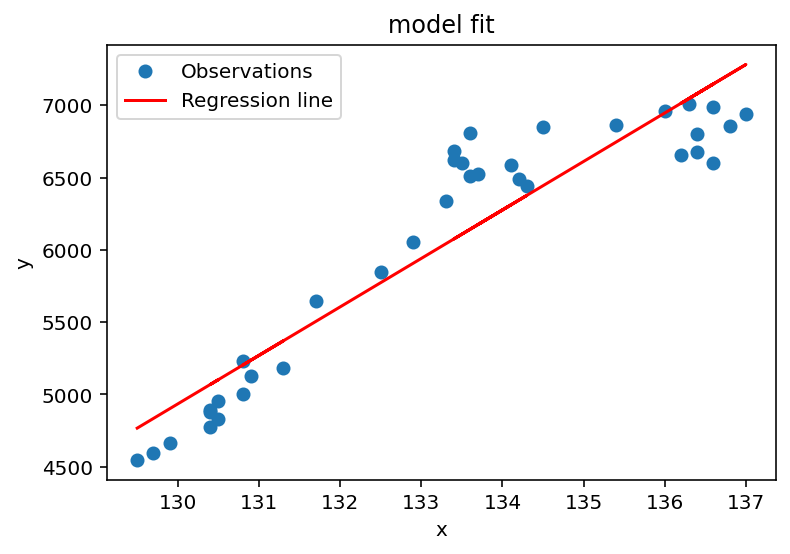

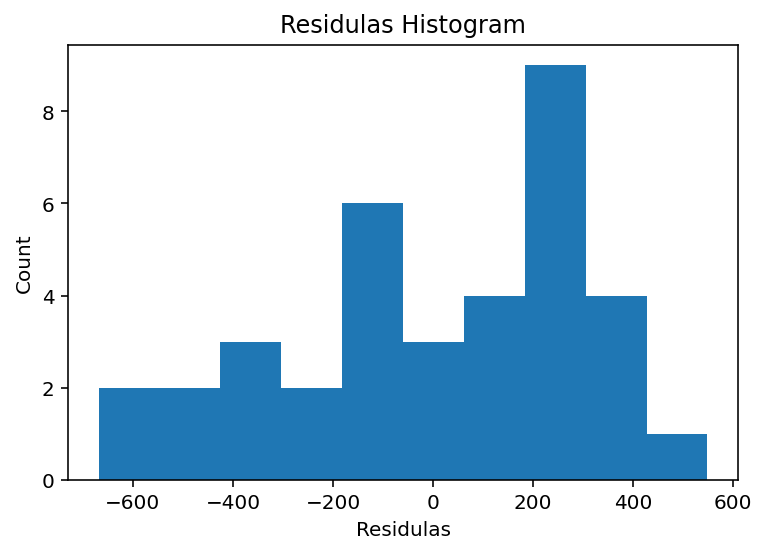

Model Residuals
count    3.600000e+01
mean    -1.952887e-11
std      3.149688e+02
min     -6.684421e+02
25%     -1.830398e+02
50%      7.202937e+01
75%      2.359488e+02
max      5.486369e+02
Name: Residuals, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     226.5
Date:                Tue, 04 Aug 2020   Prob (F-statistic):           1.34e-16
Time:                        00:06:50   Log-Likelihood:                -257.66
No. Observations:                  36   AIC:                             519.3
Df Residuals:                      34   BIC:                             522.5
Df Model:                           1                                         
Covariance Type:            nonrobust                            

In [13]:
m = sm.ols('occupancy ~ CPI', data = data)
m = m.fit()
intercept, slope = m.params
data['y_est'] = intercept + slope * data.CPI

# Calculate the residuals
data['Residuals'] = data['y_est'] - data['occupancy']

plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('model fit')

# Plot regression line
plt.plot(data.CPI, data.y_est, 'r-', label='Regression line')

# Add legend
plt.legend()
plt.show()

# We will plot the histogram of the residuals first
plt.hist(data.Residuals)

# Add axes labels
plt.xlabel('Residulas')
plt.ylabel('Count')
plt.title('Residulas Histogram')
plt.show()

# And we will print the statistical summary of the residuals,
# i.e. (median, mean, quartiles, etc.)
print('Model Residuals')
print(data['Residuals'].describe())
print('=========================')
# Print model summary 
print(m.summary())

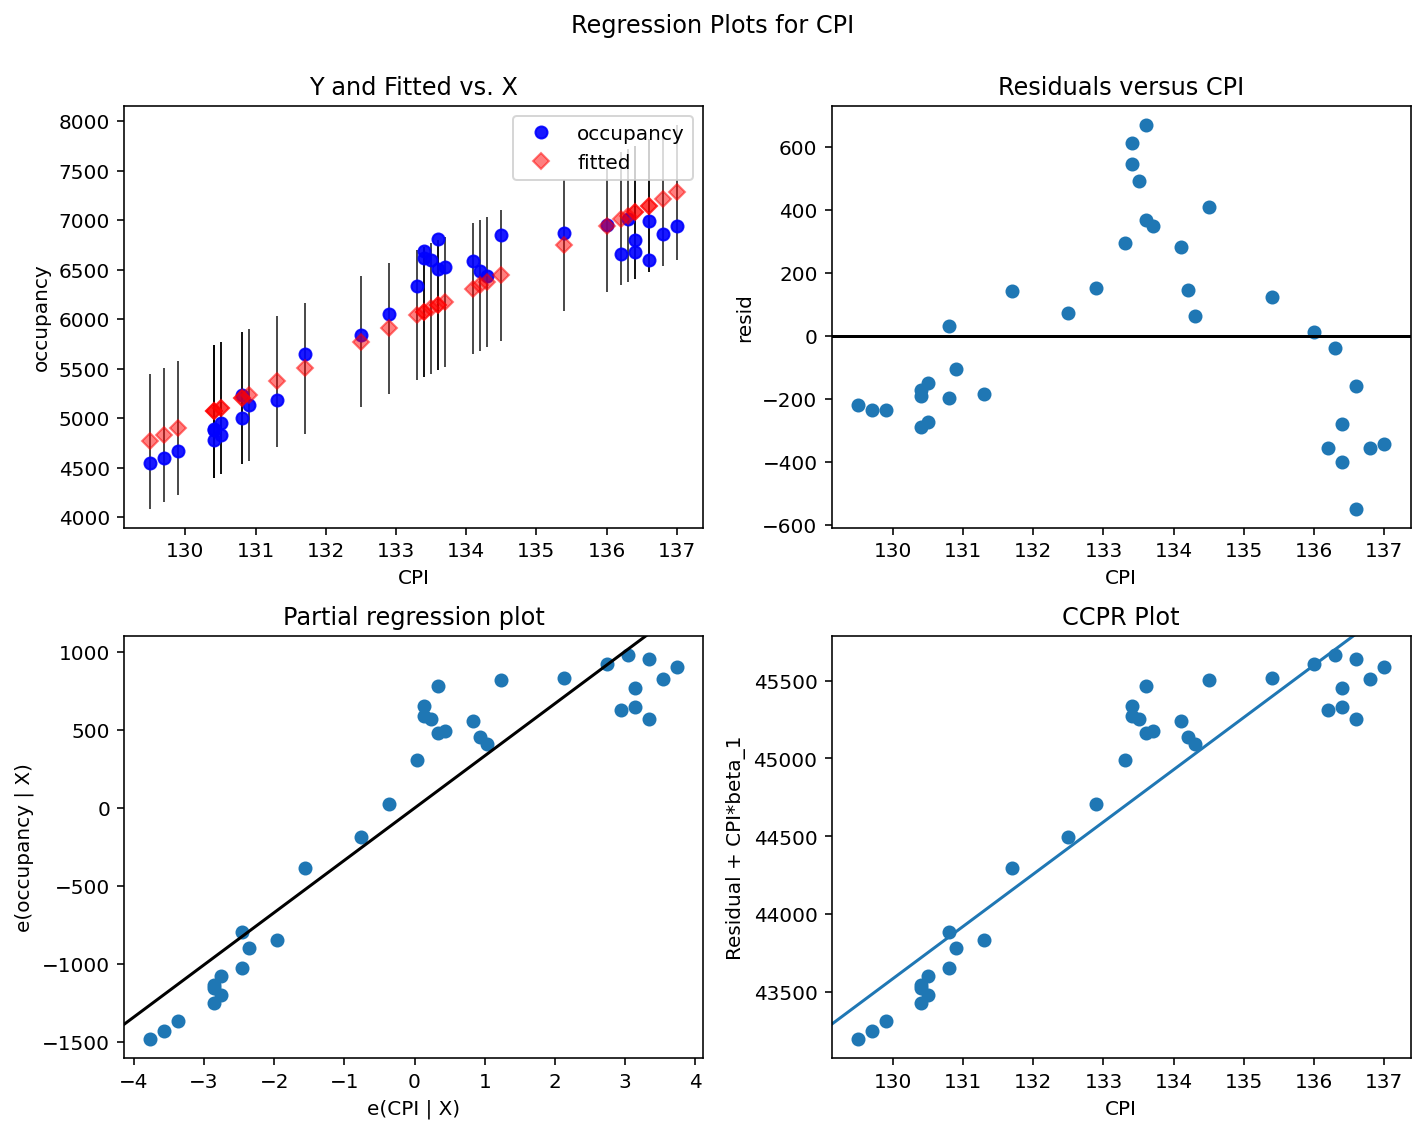

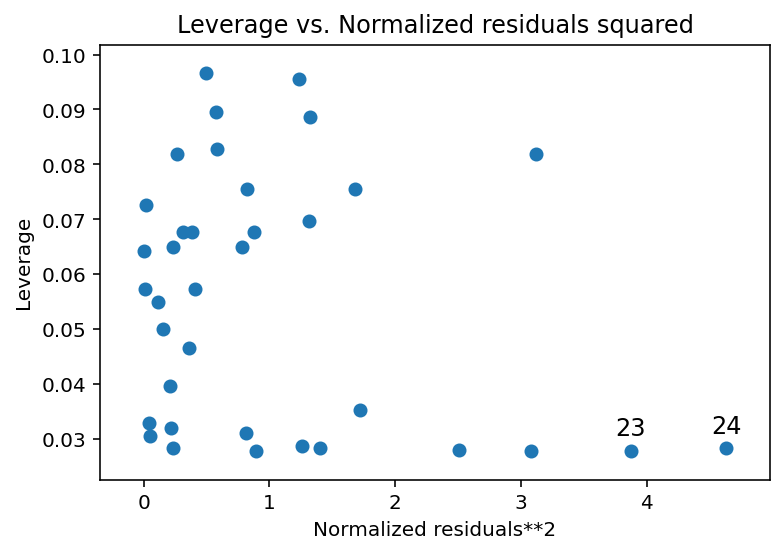

In [14]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(m, "CPI", fig = fig)
fig = plot_leverage_resid2(m)

Overall the OLS results are reasonable with good fit in terms of R-squared overall p value and significance of the model parameters with small p-values. However, as we discussed earlier regarding the sudden change in model slope beyond CPI values of 135 we can observe that from the trend between the model residuals and CPI that is clear at values of CPI>135. Next, we try to exclude the last portion of data where the sudden slope change is observed and repeat the analysis

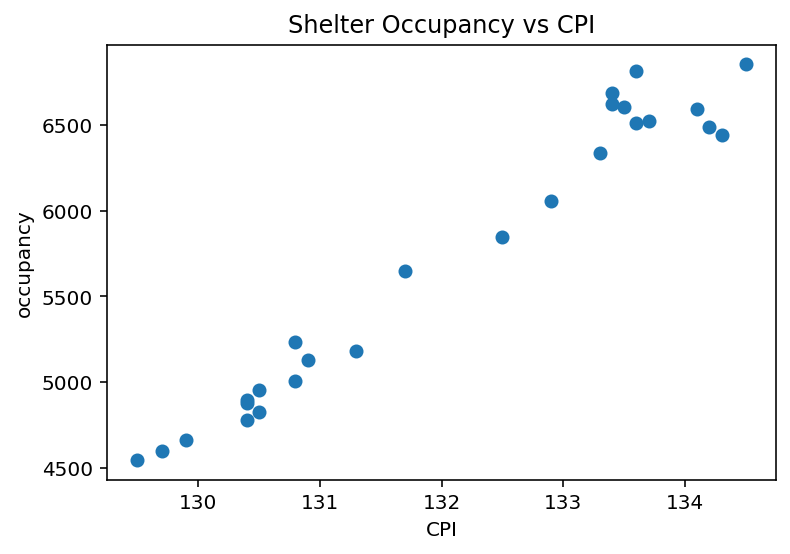

In [15]:
x = data.CPI.shift(10);
y = data.occupancy.shift(10);
plt.plot(x, y, 'o', label = 'Observations');
plt.xlabel('CPI');
plt.ylabel('occupancy');
plt.title('Shelter Occupancy vs CPI');

As we excluded the data that shown a sudden change in slope we can see now a linear model could be improved if we run OLS again 

In [16]:
x.dropna(inplace=True)
y.dropna(inplace=True)

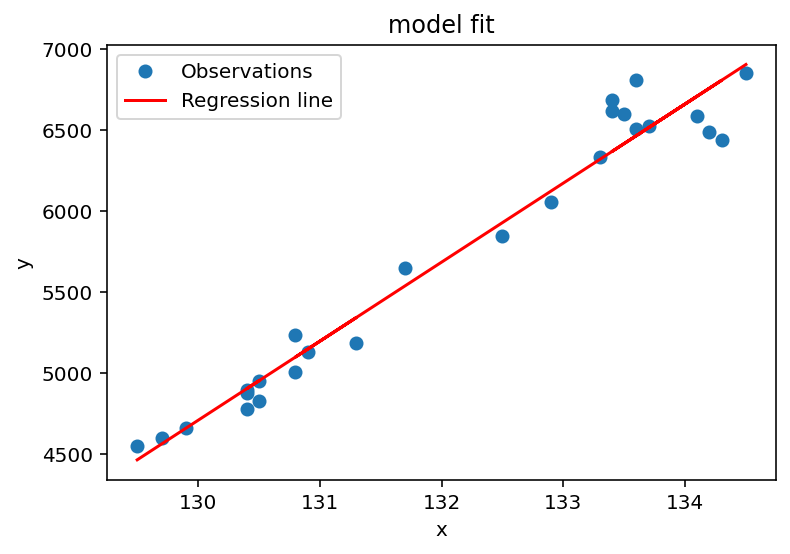

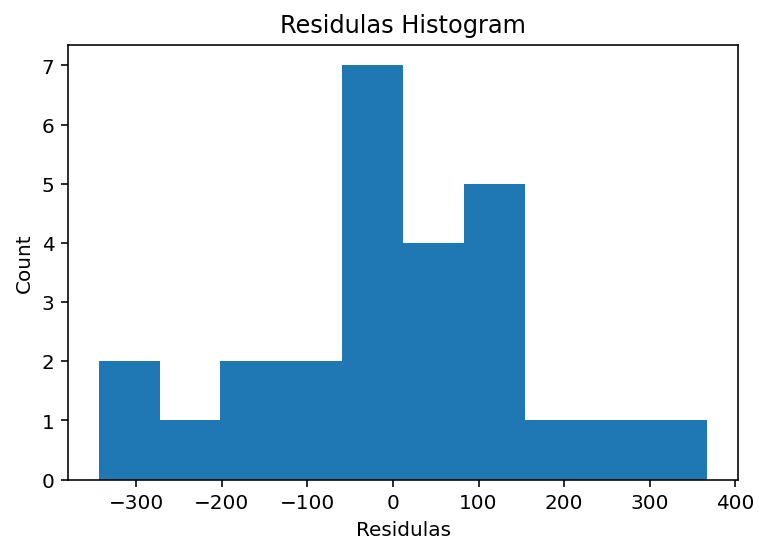

Model Residuals
count    2.600000e+01
mean    -8.570239e-12
std      1.625292e+02
min     -3.440669e+02
25%     -7.266513e+01
50%      4.889196e+00
75%      9.188056e+01
max      3.676418e+02
Name: Residuals, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     609.2
Date:                Tue, 04 Aug 2020   Prob (F-statistic):           1.44e-18
Time:                        00:06:53   Log-Likelihood:                -168.74
No. Observations:                  26   AIC:                             341.5
Df Residuals:                      24   BIC:                             344.0
Df Model:                           1                                         
Covariance Type:            nonrobust                            

In [17]:
data = pd.concat([x, y], axis=1, sort=False)
m = sm.ols('occupancy ~ CPI', data = data)
m = m.fit()
intercept, slope = m.params
data['y_est'] = intercept + slope * data.CPI

# Calculate the residuals
data['Residuals'] = data['y_est'] - data['occupancy']

plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('model fit')

# Plot regression line
plt.plot(data.CPI, data.y_est, 'r-', label='Regression line')

# Add legend
plt.legend()
plt.show()

# We will plot the histogram of the residuals first
plt.hist(data.Residuals)

# Add axes labels
plt.xlabel('Residulas')
plt.ylabel('Count')
plt.title('Residulas Histogram')
plt.show()

# And we will print the statistical summary of the residuals,
# i.e. (median, mean, quartiles, etc.)
print('Model Residuals')
print(data['Residuals'].describe())
print('=========================')
# Print model summary 
print(m.summary())

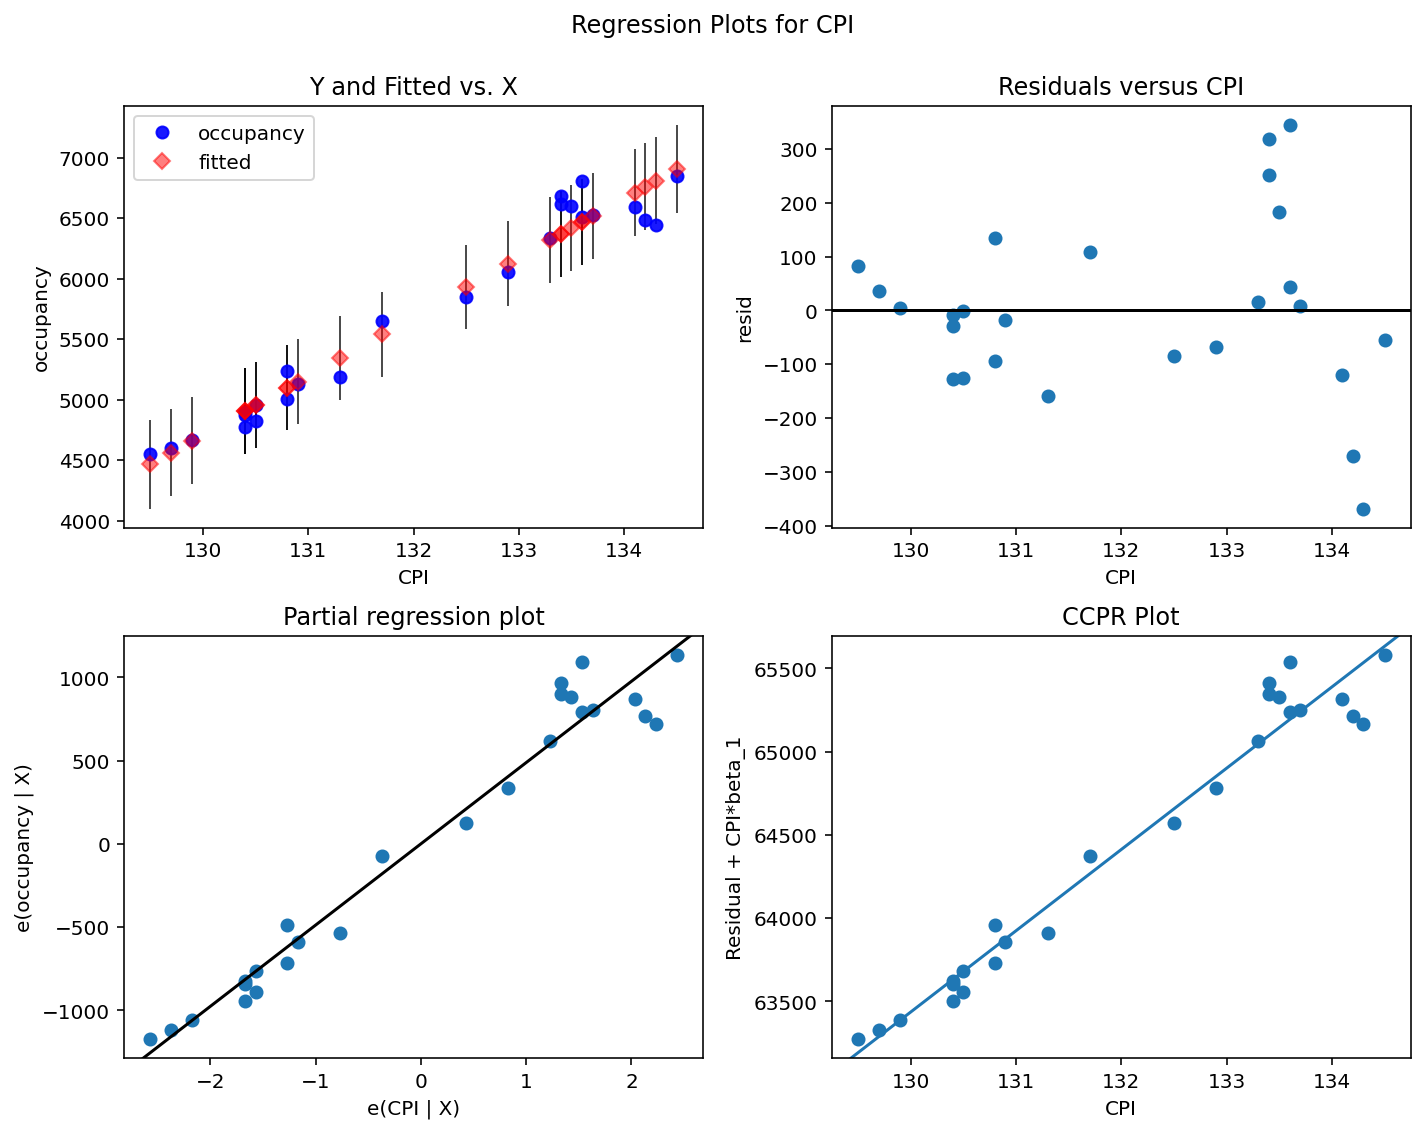

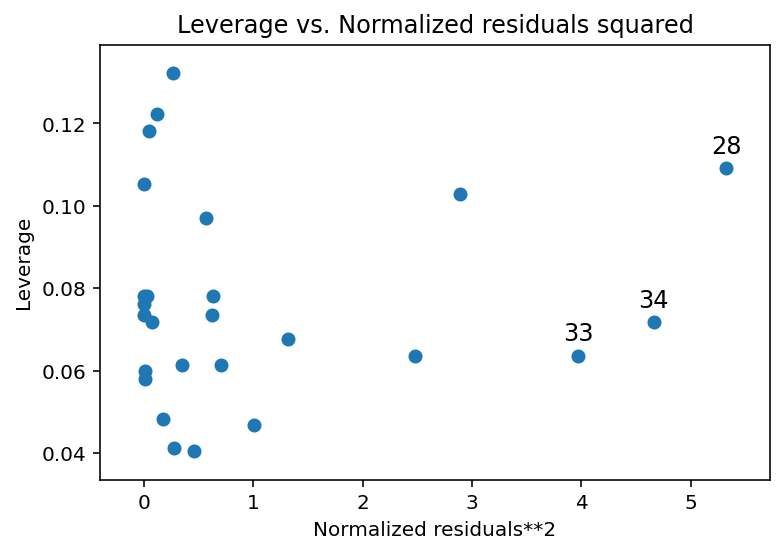

In [18]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(m, "CPI", fig = fig)
fig = plot_leverage_resid2(m)

As we can see here that model is improved in terms of ad. R-squared from 0.866 to 0.961. However, we can still see some trending in residulas vs CPI plot indicationg potential outliers and/or unmodelled factors in the model.